In [1]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# default: 100
mpl.rcParams['figure.dpi'] = 200

In [2]:
print(torch.__version__)
print(transformers.__version__)

2.0.0+cu118
4.28.0.dev0


# summary

- attention mechanism
- encoder vs. decoder
    - seq2seq
        - seq of tokens (input) => seq of tokens (output)
    - tasks
        - machine translation
    - encoder
        - seq of tokens => seq of embedding vectors(hidden state/context)
    - decoder 
        - encoder's hidden state => seq of tokens
            - iteratively generate
                - until EOS (end of seq) or reach max length limit
                - one token at a time

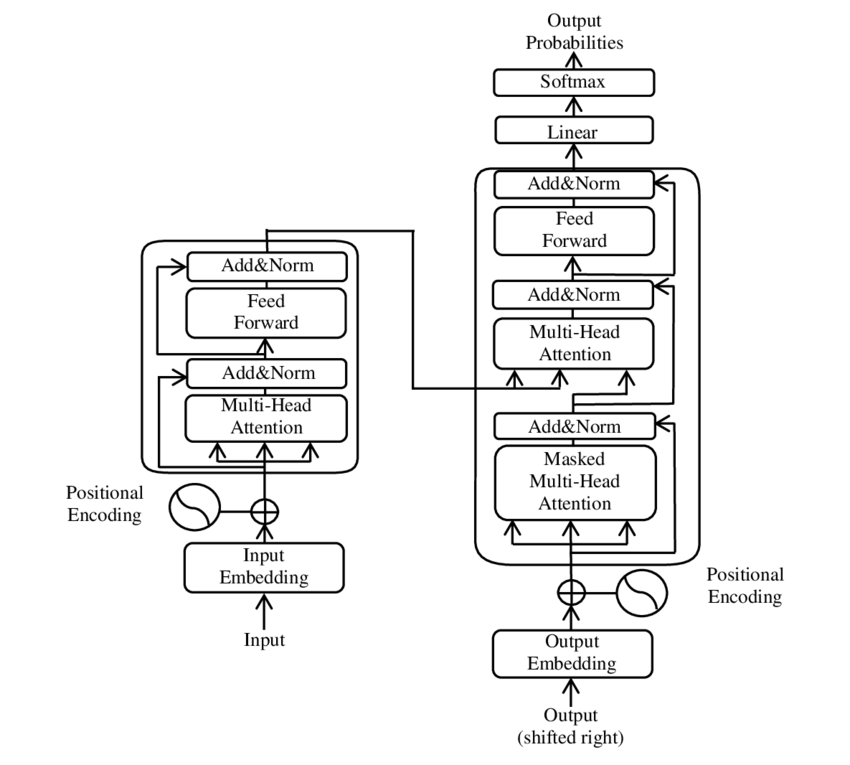

In [3]:
from IPython.display import Image
# nlp with transformers
Image('../imgs/The-Transformer-model-architecture.png')

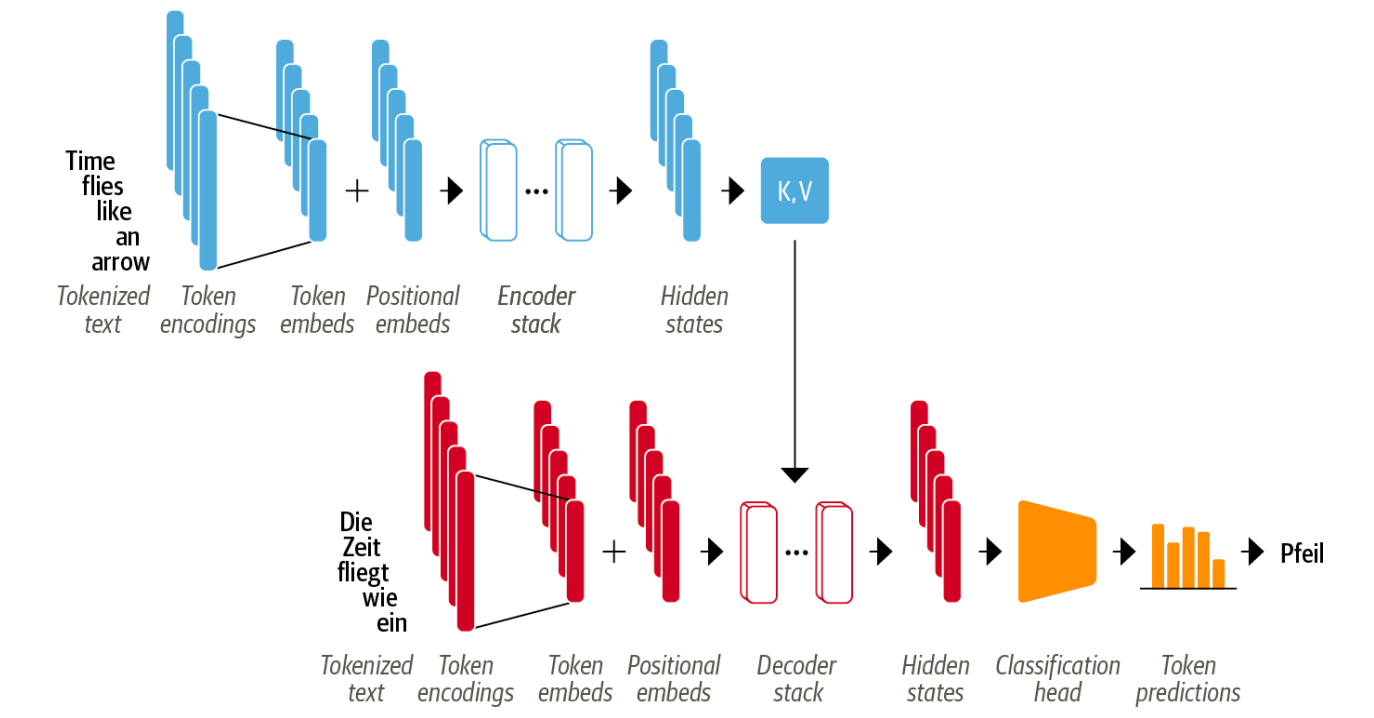

In [4]:
Image('../imgs/encoder-decoder.png', width=600)

- encoder only: seq of text => rich representation (bidirectional attention)
    - task
        - text classification
        - NER
    - models
        - BERT
        - RoBERTa
        - DistilBERT
    - 完形填空（bidirectional）
        - representation of a given token depends both on
            - left (before the token)
            - right (after the token)
- decoder only (causal or autoregressive attention)
    - gpt
    - 词语接龙
        - representation of a given token depends only on the left context；
- encoder-decoder both
    - tasks
        - machine translation
        - summarization
    - models
        - t5
        - bart

# encoder (encoder/bert layer stack)

- encoder layer: encoding the contextual information (conv)
    - input: seq of embeddings
        - multi-head self attention
        - ffn(fc)
    - output: 
        - same shape as `input`
    - contextual information (contextualized embeddings )
        - apple: company-like or fruit-like ?
           - keynote/phone/Jobs
           - banana, food, fruit
        - flies
           - time flies like an arrow：soars
           - fruit flies like a banana：insect
- skip connection (residual connection) & layer normalization
    - 高效训练深度神经网络的技巧；

## multi-head self-attention layer

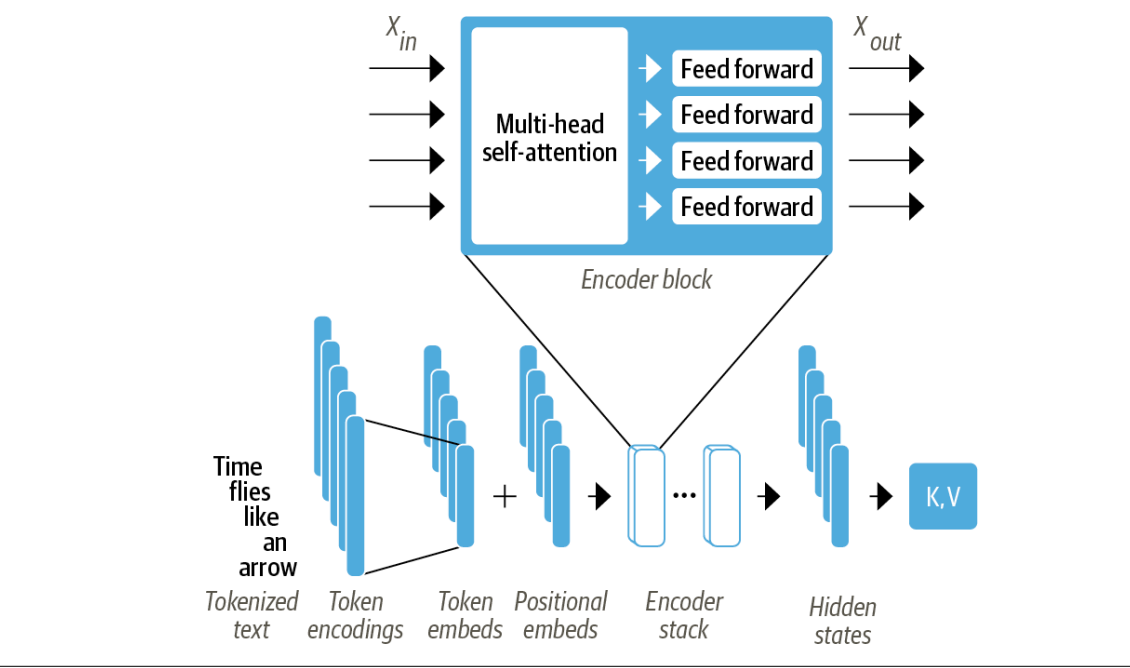

In [5]:
Image('../imgs/encoder-layer.png', width=500)

### self attention

- each token (embedding)
    - 不是 fixed embeddings 
    - 而是 weighted average of each embedding of the whole input sequence
- a seq of token embedding：$x_1, x_2, \cdots, x_n$，经过 self attention 得到 a seq of updated embeddings，$x'_1, x'_2, \cdots, x'_n$

$$
x'_i=\sum_{j=1}^n w_{ji}x_j
$$

- $w_{ji}$
    - attention weights, 
    - $\sum_{j}w_{ji}=1$
    - $w\in\mathcal R^{n\times n}$，方阵，seq_len * seq_len
    

### scaled dot-product attention

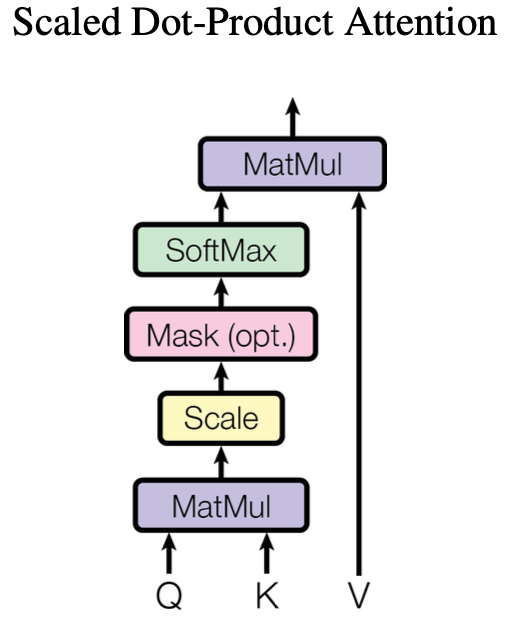

In [8]:
Image('../imgs/scaled-dot-attn-img.png', height=200)

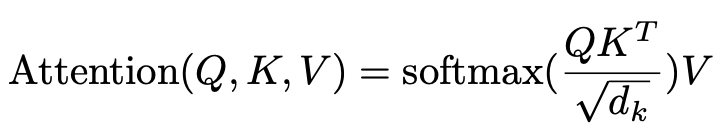

In [9]:
Image('../imgs/scaled-dot-prod-attn.png')

- Project each token embedding into three vectors called query, key, and value.
    - W_q, W_k, W_v：learnable parameters
- Compute attention **scores**. 
    - dot-product(**query, key**) => attention scores;
    - a sequence with $n$ input tokens there is a corresponding $\mathcal R^{n\times n}$ matrix of attention scores.
- Compute attention weights（$w_{j,i}$） from attention scores
    - Dot products 的结果可能是任意大的数，会让整个训练过程非常不稳定
    - 将 attention scores 乘以一个 scaling factor 
    - softmax 归一化：$\sum_{j}w_{ji}=1$
- update the final embedding of the token (**value**)
    - $x'_i=\sum_{j=1}^n w_{ji}v_j$

### visualization analysis

In [ ]:
#!pip install bertviz

In [10]:
from transformers import AutoTokenizer

In [11]:
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

In [12]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)

In [13]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

In [14]:
sample_text = 'time flies like an arrow'
show(model, model_type="bert", tokenizer=tokenizer, sentence_a=sample_text, 
     display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

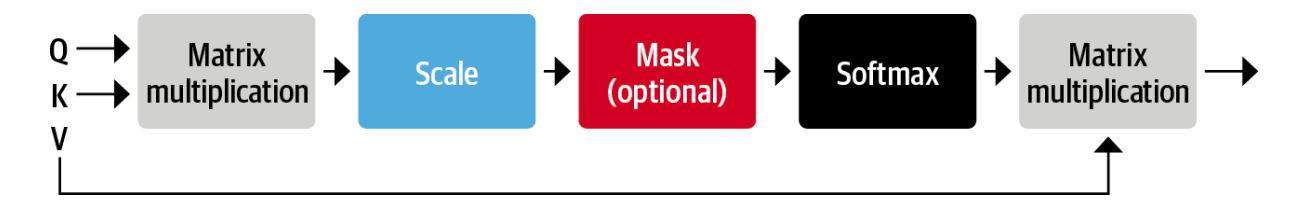

In [15]:
Image('../imgs/qkv.png')

- 稍微解释下 query, key, value
    - information retrieval systems
    - 你要做一顿晚餐
        - 晚餐的内容就是 queries
        - 现在你在一个超市，超市的货架上的 labels 就是 keys
        - querys 和 keys 进行匹配，得到最合适的货架和层
        - 然后从匹配到的货架和层取出对应的 item（values）

### computation of self-attention

In [17]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [18]:
sample_text

'time flies like an arrow'

In [16]:
# [CLS][SEP]
model_inputs = tokenizer(sample_text, return_tensors='pt', add_special_tokens=False)
model_inputs

{'input_ids': tensor([[ 2051, 10029,  2066,  2019,  8612]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [23]:
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModel

In [20]:
# hyperparameters
config = AutoConfig.from_pretrained(model_ckpt)
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [26]:
# config.vocab_size: 30522, 
# config.hidden_size: 768=64*12
# lookup-table, learnable
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
token_embedding

Embedding(30522, 768)

In [28]:
print(model_inputs['input_ids'].shape)
model_inputs['input_ids']

torch.Size([1, 5])


tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [29]:
# forward of embedding module
input_embeddings = token_embedding(model_inputs['input_ids'])
# batch_size, seq_len, hidden_size
input_embeddings.shape

torch.Size([1, 5, 768])

In [30]:
# 暂时先不考虑 position encoding
# query: [1, 5, 768], key: [1, 5, 768], value: [1, 5, 768]
# W_q, W_k, W_v: nn.Linear，作用在 token_embedding 得到，或者说依然是通过 learning 最终确定的
query = key = value = input_embeddings
dim_k = key.size(-1)
print('dim_k: ', dim_k)
# /np.sqrt(dim_k): scaling factor to stablize the training process
# avoid the saturate of softmax: grad => zero
attn_scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k)
print('attn_scores.shape: ', attn_scores.shape)
attn_scores

dim_k:  768
attn_scores.shape:  torch.Size([1, 5, 5])


tensor([[[27.9989,  0.5235, -1.9310, -1.9866,  0.2585],
         [ 0.5235, 29.1748, -0.1630,  0.7868, -1.4294],
         [-1.9310, -0.1630, 27.0096, -0.8972, -0.1020],
         [-1.9866,  0.7868, -0.8972, 28.9856,  0.7115],
         [ 0.2585, -1.4294, -0.1020,  0.7115, 27.4751]]],
       grad_fn=<DivBackward0>)

In [32]:
# from scores => weights, softmax
import torch.nn.functional as F
attn_weights = F.softmax(attn_scores, dim=-1)
attn_weights

tensor([[[1.0000e+00, 1.1683e-12, 1.0037e-13, 9.4935e-14, 8.9637e-13],
         [3.6049e-13, 1.0000e+00, 1.8145e-13, 4.6910e-13, 5.1142e-14],
         [2.6995e-13, 1.5816e-12, 1.0000e+00, 7.5900e-13, 1.6811e-12],
         [3.5395e-14, 5.6682e-13, 1.0522e-13, 1.0000e+00, 5.2567e-13],
         [1.5135e-12, 2.7987e-13, 1.0554e-12, 2.3807e-12, 1.0000e+00]]],
       grad_fn=<SoftmaxBackward0>)

In [34]:
attn_weights.sum(axis=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [35]:
# 5*5, 5*768 => 5*768
attn_outputs = torch.bmm(attn_weights, value)
attn_outputs

tensor([[[-1.3950,  0.5791, -1.0480,  ..., -0.6396,  0.1464,  0.3892],
         [-0.5745,  0.1738, -1.6579,  ...,  0.7793, -1.0431,  0.2658],
         [ 1.2183,  1.0754, -0.8989,  ...,  1.0312, -0.4550,  1.5209],
         [-0.6040, -0.5614, -0.1848,  ..., -0.0242,  1.1683,  0.3991],
         [-1.1232, -1.1936, -0.2359,  ..., -0.6042,  0.7185,  0.1535]]],
       grad_fn=<BmmBackward0>)

In [38]:
# batch_size, seq_len, hidden_size
def scaled_dot_product_attention(query, key, value):
    # hidden_size
    dim_k = key.size(-1)
    # batch_size, seq_len, seq_len
    attn_scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k)
    attn_weights = F.softmax(attn_scores, dim=-1)
    return torch.bmm(attn_weights, value)

In [40]:
scaled_dot_product_attention(query, key, value)

tensor([[[-1.3950,  0.5791, -1.0480,  ..., -0.6396,  0.1464,  0.3892],
         [-0.5745,  0.1738, -1.6579,  ...,  0.7793, -1.0431,  0.2658],
         [ 1.2183,  1.0754, -0.8989,  ...,  1.0312, -0.4550,  1.5209],
         [-0.6040, -0.5614, -0.1848,  ..., -0.0242,  1.1683,  0.3991],
         [-1.1232, -1.1936, -0.2359,  ..., -0.6042,  0.7185,  0.1535]]],
       grad_fn=<BmmBackward0>)